### Download fastText and facebook infersent models
Followed steps at: https://github.com/facebookresearch/InferSent

In [51]:
import nltk
nltk.download('punkt')
import sys
sys.path.append("../lib/Infersent")
from models import InferSent
import torch
import pandas as pd
import spacy
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ryanstonebraker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load('../models/encoder/infersent2.pkl'))
infersent.set_w2v_path("../models/fastText/crawl-300d-2M.vec")

In [21]:
squad_df = pd.read_csv("../corpora/squad-dev-v2.0.csv", index_col=0)
squad_df.head()

,contexts,questions,answer_texts,answer_starts
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94
2,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries,87
3,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256
4,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308


In [29]:
nlp = spacy.load("en")

In [36]:
sentences = []

contexts = list(squad_df["contexts"].drop_duplicates())
for context in contexts:
    doc = nlp(context)
    sentences += [sentence.string.strip() for sentence in doc.sents]

In [37]:
infersent.build_vocab(sentences, tokenize=True)

Found 18481(/19809) words with w2v vectors
Vocab size : 18481


In [38]:
embeddings = infersent.encode(sentences, tokenize=True)

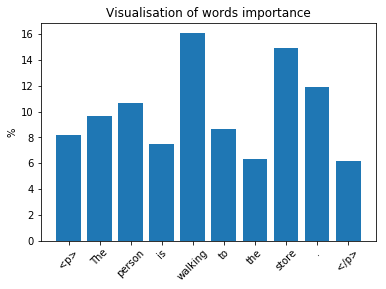

(tensor([[ 0.0075, -0.0281,  0.0683,  ..., -0.0171, -0.0331, -0.0084]],
        grad_fn=<MaxBackward0>), array([[0, 2, 4, ..., 7, 5, 1]]))

In [43]:
infersent.visualize('The person is walking to the store.', tokenize=True)

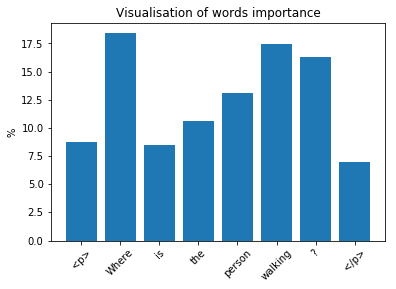

(tensor([[ 0.0075, -0.0292,  0.0551,  ..., -0.0055, -0.0356, -0.0193]],
        grad_fn=<MaxBackward0>), array([[0, 1, 5, ..., 3, 6, 1]]))

In [44]:
infersent.visualize('Where is the person walking?', tokenize=True)

In [50]:
def cosine_similarity(text1, text2):
    return np.dot(text1, text2)/(np.linalg.norm(text1) * np.linalg.norm(text2))

In [ ]:
def cosine_predict(statements, question):
    doc = nlp(statements)
    context_sentences = [sentence.string.strip() for sentence in doc.sents]
    most_similar, highest_sim = "", 0
    for sentence in context_sentences:
        similarity = cosine_similarity(infersent.encode([questiion])[0], infersent.encode([sentence])[0])
        if similarity > highest_sim:
            most_similar = sentence
            highest_sim = similarity
    return most_similar, highest_sim

In [ ]:
correct_answers = 0
for i, row in squad_df.iterrows():
    most_similar, accuracy = cosine_predict(row["contexts"], row["questions"])
    
    correct_answers += 1 if row["answer_texts"] in most_similar else 0

print("Cosine Similarity Accuracy:", correct_answers/squad_df.shape[0])